In [109]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt


Functions

In [110]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def relu(x):
  return np.maximum(0,x)  

def softmax(X):
  return np.exp(X)/(np.sum(np.exp(X),axis=1).reshape(-1,1))   

def sigmoid_p(x):
  return sigmoid(x)*(1-sigmoid(x))

def relu_p(x):
  return 1*(x >= 0)    
  
def h(act,x):
  if act == 'sigmoid':
    return sigmoid(x)
  if act == 'relu':
    return relu(x)
  if act == 'identity':
    return x
  if act == 'tanh':
    return np.tanh(x)
  if act == 'softmax':
    return softmax(x)
  return 'Problem'  

def h_p(act,x):
  if act == 'sigmoid':
    return sigmoid_p(x)
  if act == 'relu':
    return relu_p(x)
  if act == 'identity':
    return np.ones(x.shape)
  if act == 'tanh':
    return 1/(np.cosh(x))**2
  return 'Problem'    

One fully connected layer

In [111]:
def affine(b,W,X):
  return b + np.matmul(X,W)

# When a layer is fully connected
# input: b, W, parameters of the layer, activ is a string that tell us 
# the activation function of the layer, X data of the previous layer (after 
# flatteting if necessary, so X is a 2d tensor)
# output: A, data of the layer, and the corresponding Z
def fully_connected(b,W,activ,X):
  Z = affine(b,W,X)  
  A = h(activ,Z)
  return A, Z

One convolutional layer

In [112]:
def padding(p,A):
  return np.pad(A,((0,0),(p,p),(p,p),(0,0)))

def conv(W,s,A):
  f = W.shape[0]
  n_e = A.shape[0]
  n_h = (A.shape[1]-f)//s + 1
  n_w = (A.shape[2]-f)//s + 1
  n_c = W.shape[3]
  A_conv_W = np.zeros((n_e,n_h,n_w,n_c))
  for i_e in range(n_e):
    for i_h in range(n_h):
      for i_w in range(n_w):
        for i_c in range(n_c):
          A_conv_W[i_e,i_h,i_w,i_c] = np.sum(A[i_e,i_h*s:i_h*s+f,i_w*s:i_w*s+f,:]*W[:,:,:,i_c])
  return A_conv_W  

# When a layer is convolutional 
# input: b, W, parameters of the layer, s =stride, p = padding, activ is a 
# string that tell us the activation function of the layer, X data of the previous layer 
# (X is a 4d tensor)
# output: A, data of the layer, and the corresponding Z

def convolutional(b,W,s,p,activ,X):
  Z = conv(W,s,padding(p,X))+b
  A = h(activ,Z)
  return A, Z

One pooling layer

In [113]:
def pooling(f,s,A):
  n_e = A.shape[0]
  n_h = (A.shape[1]-f)//s + 1
  n_w = (A.shape[2]-f)//s + 1
  n_c = A.shape[3]
  A_pool = np.zeros((n_e,n_h,n_w,n_c))
  Z = []
  for i_e in range(n_e):
    for i_h in range(n_h):
      for i_w in range(n_w):
        for i_c in range(n_c):
          x = np.argmax(A[i_e,i_h*s:i_h*s+f,i_w*s:i_w*s+f,i_c])
          i_w_max = x%f + i_w*s
          i_h_max = x//f + i_h*s
          Z.append((i_e,i_h_max,i_w_max,i_c))
          A_pool[i_e,i_w,i_h,i_c] = A[i_e,i_w_max,i_h_max,i_c]
  return A_pool, Z  

Input data

Features in X. X.shape = (n_e, n_h, n_w, n_c) n_e = number of examples n_c = 3 if color images. n_c = 1 if black and white image 

Labels in Y. Y.shape = (n_e, n_cat) n_cat = number of categories

Type network (hyperparameters)

activation = [None, '','',....... ] relu, sigmoid, tanh, softmax, lin

layer_type = [None, '','',.....] convolutional_layer, pooling_layer, dense_layer

shape_data = [X.shape[1:], (), (),....] shape of the data in the layer without the first component, that corresponds to the number of example

paddings = [None,,,.....] some are numbers, some are None

strides = [None,,,.....] some are numbers, some are None

filters_sizes = [None,,,.....] some are numbers, some are None

L = number of layers not counting the input layer 

L = len(shape_data) - 1

Finding the first fully connected layer

In [114]:
def first_dense_layer(layer_type):
  l = 1
  while layer_type[l] != 'dense_layer':
    l = l+1 
  return l

Computing the A_l, data in the layers, and Z_l, the data before applying activation or the indices in the pooling layers 

In [115]:
def data_next_layer(W,b,activ,layer_type,filter_size,stride,p,A):
  if layer_type == 'dense_layer':
    return fully_connected(b,W,activ,A)
  if layer_type == 'convolutional_layer':
    return convolutional(b,W,stride,p,activ,A)
  if layer_type == 'pooling_layer':
    return pooling(filter_size,stride,A)

def data_in_layers(W,b,activation,layer_type,filters_sizes,strides,paddings,first_dense,L,X):
  A = [X]
  Z = [None]
  for l in range(1,L+1):
    A_prev = A[l-1]
    if l == first_dense:
      A_prev = A_prev.reshape((A_prev.shape[0],-1))
    A_l, Z_l = data_next_layer(W[l],b[l],activation[l],layer_type[l],filters_sizes[l],strides[l],paddings[l],A_prev)
    A.append(A_l)
    Z.append(Z_l)
  return A, Z  

Predictions

In [116]:
def predictions(W,b,activation,layer_type,filters_sizes,strides,paddings,first_dense,L,X):
  A, Z = data_in_layers(W,b,activation,layer_type,filters_sizes,strides,paddings,first_dense,L,X)
  return A[-1]    

Cross entropy error

In [117]:
def error_cross_entropy(Y,Y_hat):
  return -np.sum(Y*np.log(Y_hat))/Y.shape[0]

DJ/DA in the last layer

In [118]:
def DJ_DA_L(Y,A_L):
  return -(Y/A_L)/Y.shape[0]  

DJ/DZ in the last layer

In [119]:
def DJ_DZ_L(Y,A_L):
  return (A_L-Y)/Y.shape[0]  

One fully connected layer. Backward to compute gradients

In [120]:
def gradients_one_layer_dense(l,activ,b,W,Z,A,A_prev,DJ_DA,Y,first_dense):
  if activ == 'softmax':
    DJ_DZ = DJ_DZ_L(Y,A)
  else:  
    DJ_DZ = DJ_DA*h_p(activ,Z)
  DJ_Db = np.sum(DJ_DZ,axis=0)
  if l == first_dense:
    A_prev = A_prev.reshape((A_prev.shape[0],-1))
  DJ_DW = np.matmul(A_prev.T,DJ_DZ)
  DJ_DA_prev = None
  if l != 1:
    DJ_DA_prev = np.matmul(DJ_DZ,W.T)
  return DJ_Db, DJ_DW, DJ_DA_prev

One convolutional layer. Backward to compute gradients

In [121]:
def DJ_DW_conv(W_shape,DJ_DZ,A_prev_pad,s): 
  DJ_DW = np.zeros(W_shape)
  for i1 in range(W_shape[0]):
    ind_1 = np.arange(i1,(DJ_DZ.shape[1]-1)*s+i1+1,s)
    for i2 in range(W_shape[1]):
      ind_2 = np.arange(i2,(DJ_DZ.shape[2]-1)*s+i2+1,s)
      for i3 in range(W_shape[2]):
        A_res = A_prev_pad[:,:,:,i3]
        A_res = A_res[:,:,ind_2]
        A_res = A_res[:,ind_1,:]
        for i4 in range(W_shape[3]):
          DJ_DW[i1,i2,i3,i4] = np.sum(DJ_DZ[:,:,:,i4]*A_res)
  return DJ_DW    

def DJ_DA_prev_conv(A_prev_shape,DJ_DZ,W,p,s):
  f = W.shape[0]
  DJ_DA_prev = np.zeros(A_prev_shape)
  for i1 in range(A_prev_shape[0]):
    for i2 in range(A_prev_shape[1]):
      a2_min = max((i2+p-f)//s+1,0)
      a2_max = min((i2+p)//s,DJ_DZ.shape[1]-1)
      ind_0 = np.arange(i2+p-a2_min*s,i2+p-a2_max*s-1,-s)
      for i3 in range(A_prev_shape[2]):
        a3_min = max((i3+p-f)//s+1,0)
        a3_max = min((i3+p)//s,DJ_DZ.shape[2]-1)
        ind_1 = np.arange(i3+p-a3_min*s,i3+p-a3_max*s-1,-s)
        DJ_DZ_res = DJ_DZ[i1,:,:,:]
        DJ_DZ_res = DJ_DZ_res[:,a3_min:a3_max+1,:]
        DJ_DZ_res = DJ_DZ_res[a2_min:a2_max+1,:,:]
        for i4 in range(A_prev_shape[3]):
          W_res = W[:,:,i4,:]
          W_res = W_res[:,ind_1,:]
          W_res = W_res[ind_0,:,:]
          DJ_DA_prev[i1,i2,i3,i4] = np.sum(DJ_DZ_res*W_res)
  return DJ_DA_prev

def gradients_one_layer_convolutional(l,activ,p,s,b,W,Z,A,A_prev,DJ_DA):
  A_prev_pad = padding(p,A_prev)
  DJ_DZ = DJ_DA*h_p(activ,Z)
  DJ_Db = np.sum(DJ_DZ,axis=(0,1,2))
  DJ_DW = DJ_DW_conv(W.shape,DJ_DZ,A_prev_pad,s)
  DJ_DA_prev = None
  if l != 1:
    DJ_DA_prev = DJ_DA_prev_conv(A_prev.shape,DJ_DZ,W,p,s)
  return DJ_Db, DJ_DW, DJ_DA_prev

One pooling layer. Backward to compute gradients

In [122]:
def gradients_one_layer_pooling(l,Z,A,A_prev,DJ_DA):
  n_e = A.shape[0]
  n_h = A.shape[1]
  n_w = A.shape[2]
  n_c = A.shape[3]
  DJ_DA_prev = np.zeros(A_prev.shape)
  if l == 1:
    return None, None, DJ_DA_prev
  i = 0
  for i_e in range(n_e):
    for i_h in range(n_h):
      for i_w in range(n_w):
        for i_c in range(n_c):
          DJ_DA_prev[Z[i]] = DJ_DA_prev[Z[i]] + DJ_DA[i_e,i_h,i_w,i_c] 
          i = i+1 
  return None, None, DJ_DA_prev

Gradients in all the layers

In [123]:
def gradients_one_layer(l,layer_type,activ,p,s,b,W,Z,A,A_prev,DJ_DA,Y,first_dense):
  if layer_type == 'dense_layer':
    return gradients_one_layer_dense(l,activ,b,W,Z,A,A_prev,DJ_DA,Y,first_dense)
  if layer_type == 'convolutional_layer':
    return gradients_one_layer_convolutional(l,activ,p,s,b,W,Z,A,A_prev,DJ_DA)
  if layer_type == 'pooling_layer':
    return gradients_one_layer_pooling(l,Z,A,A_prev,DJ_DA)

def gradients_all_layers(W,b,activation,layer_type,strides,paddings,first_dense,L,A,Z,Y):
  DJ_DA = [DJ_DA_L(Y,A[-1])]
  DJ_Db = []
  DJ_DW = []
  l = L
  while l > 0:
    DJ_Db_l, DJ_DW_l, DJ_DA_l_1 = gradients_one_layer(l,layer_type[l],activation[l],paddings[l],strides[l],b[l],W[l],Z[l],A[l],A[l-1],DJ_DA[0],Y,first_dense)
    if l == first_dense:
      DJ_DA_l_1 = DJ_DA_l_1.reshape(A[l-1].shape)    
    DJ_DA.insert(0,DJ_DA_l_1)
    DJ_Db.insert(0,DJ_Db_l)
    DJ_DW.insert(0,DJ_DW_l)
    l = l-1
  DJ_Db.insert(0,None)
  DJ_DW.insert(0,None)  
  return DJ_Db, DJ_DW  


Initializing the parameters

In [124]:
def initialize_a_W_and_b(layer_type,shape_input,shape_output,filter_size,need_to_flatten):
  if need_to_flatten:
    s_i_f = shape_input[0]*shape_input[1]*shape_input[2]
    W = np.random.randn(s_i_f,shape_output)/np.sqrt(s_i_f)
    b = np.zeros(shape_output)
    return W, b 
  if layer_type == 'dense_layer':
    W = np.random.randn(shape_input,shape_output)/np.sqrt(shape_input)
    b = np.zeros(shape_output)
    return W, b
  if layer_type == 'convolutional_layer':
    s_i_f = shape_input[0]*shape_input[1]*shape_input[2]
    W = np.random.randn(filter_size,filter_size,shape_input[2],shape_output[2])/np.sqrt(s_i_f)
    b = np.zeros(shape_output[2])
    return W, b
  return None, None  

def initialize_all_W_and_b(layer_type,shape_data,L,filters_sizes,first_dense):
  W = [None]
  b = [None,]
  for l in range(1,L+1):
    need_to_flatten = (l == first_dense)
    W_l, b_l = initialize_a_W_and_b(layer_type[l],shape_data[l-1],shape_data[l],filters_sizes[l],need_to_flatten)
    W.append(W_l)
    b.append(b_l)
  return W, b 

Computing the accuracy

In [130]:
# y is a one dimensional array y_1d = [0,2,1,3,0,2] (the categories of the examples)
# y_hat is 2d
def accuracy(Y_hat,y_1d):
  y_hat_1d = np.argmax(Y_hat,axis=1)
  correct_predictions = np.sum(y_hat_1d == y_1d)
  predictions = len(y_1d)
  accuracy = correct_predictions/predictions
  return accuracy

One step of steepest descent

In [131]:
def one_step(W,b,activation,layer_type,filters_sizes,strides,paddings,first_dense,L,X,Y,c,la,y_1d):
  n_e = X.shape[0]
  A, Z = data_in_layers(W,b,activation,layer_type,filters_sizes,strides,paddings,first_dense,L,X)
  error = error_cross_entropy(Y,A[-1])
  ac = accuracy(A[-1],y_1d)
  DJ_Db, DJ_DW = gradients_all_layers(W,b,activation,layer_type,strides,paddings,first_dense,L,A,Z,Y)
  for l in range(1,L+1):
    if layer_type[l] != 'pooling_layer':
      b[l] = b[l] - c*DJ_Db[l] - 2*la[l]*b[l]/n_e 
      W[l] = W[l] - c*DJ_DW[l] - 2*la[l]*W[l]/n_e
  return b, W, error, ac  

Steepest descent

In [132]:
def all_steps(shape_data,activation,layer_type,filters_sizes,strides,paddings,first_dense,L,X,Y,c,n_steps,la,y_1d):
  W, b = initialize_all_W_and_b(layer_type,shape_data,L,filters_sizes,first_dense)
  J = np.array([])
  Ac = np.array([])
  for i in range(n_steps):
    print(i)
    b, W, error, acc = one_step(W,b,activation,layer_type,filters_sizes,strides,paddings,first_dense,L,X,Y,c,la,y_1d)
    J = np.append(J,error)
    Ac = np.append(Ac,acc)
    print(error,acc)
  return b, W, J, Ac

Load MNINST data

In [133]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [135]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

4

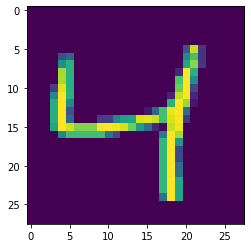

In [137]:
x_train.shape
plt.imshow(x_train[2,:,:])
y_train[2]

In [138]:
x_small = np.zeros((1200,28,28))
y_small = np.zeros(1200,dtype=int)
i = 0
j = 0
while i < 600:
  if y_train[j] == 0:
    x_small[i,:,:] = x_train[j,:,:]
    y_small[i] = int(0)
    i = i+1
  j = j+1   
while i < 1200:
  if y_train[j] == 1:
    x_small[i,:,:] = x_train[j,:,:]
    y_small[i] = int(1)
    i = i+1
  j = j+1   

1

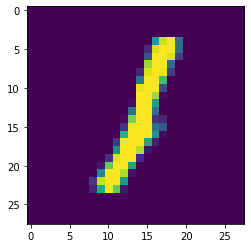

In [142]:
x_small.shape
plt.imshow(x_small[702,:,:])
y_small[702]

In [143]:
y_small

array([0, 0, 0, ..., 1, 1, 1])

In [144]:
def shuffle_examples(X,Y):
  p = np.random.permutation(len(X))
  return X[p],Y[p]

x_small,y_small = shuffle_examples(x_small,y_small)

1

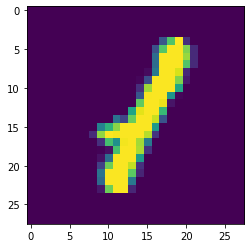

In [146]:
plt.imshow(x_small[0,:,:])
y_small[0]

In [147]:
x_small_train = x_small[:1000,:,:].reshape(1000,28,28,1)
x_small_test = x_small[1000:,:,:].reshape(200,28,28,1)
y_small_train = y_small[:1000]
y_small_test = y_small[1000:]

In [148]:
x_train_scaled = x_small_train/255

In [149]:
def labels_1d_2d(y,n_c):
  return 1*(np.arange(n_c).reshape(1,n_c) == y.reshape(len(y),1))   

In [150]:
y_small_train

array([1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,

In [151]:
y_train_cat = labels_1d_2d(y_small_train,2)

In [153]:
y_train_cat[:3,:]

array([[0, 1],
       [0, 1],
       [1, 0]])

In [156]:
y_small_train[:3]

array([1, 1, 0])

In [157]:
activation = [None,'relu',None,'relu','softmax']
layer_type = [None,'convolutional_layer','pooling_layer','dense_layer','dense_layer']
shape_data = [x_train_scaled.shape[1:],(25,25,8),(24,24,8),(32),(2)]
paddings = [None,0,None,None,None]
strides = [None,1,1,None,None]
filters_sizes = [None,4,2,None,None]
L = len(shape_data) - 1
la = [None,0,None,0,0]

In [158]:
first_dense = first_dense_layer(layer_type)
c = 0.1
n_steps = 10

In [159]:
b, W, J, Ac = all_steps(shape_data,activation,layer_type,filters_sizes,strides,paddings,first_dense,L,x_train_scaled,y_train_cat,c,n_steps,la,y_small_train)

0
0.6974798707116079 0.326
1
0.6811969850046073 0.916
2
0.6625550578224261 0.975
3
0.6260433120287605 0.987
4
0.5474517860809682 0.993
5
0.4007203631396358 0.995
6
0.23450871855392844 0.996
7
0.12974594984298207 0.996
8
0.08278239949202792 0.996
9
0.05833517413159342 0.996


In [164]:
x_test_scaled = x_small_test/255
y_hat_test = predictions(W,b,activation,layer_type,filters_sizes,strides,paddings,first_dense,L,x_test_scaled)
accuracy(y_hat_test,y_small_test)


1.0

array([0.99776916, 0.00223084])

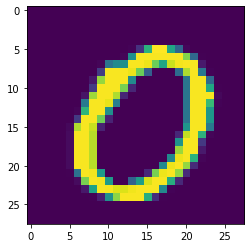

In [167]:
plt.imshow(x_small_test[113,:,:,0])
y_hat_test[113]